# CIS 5450 Homework 5: Time-Series Machine Learning

### Due April 30th, 2025

Welcome to CIS 5450 Homework 5! In this part of the HW, we will be reviewing time-series models and machine learning methods.

**Grading:** Please note that this HW will be graded as an extra credit for the class.





# Libraries and Setup Jargon [1 point]
Run the following cells to set up the notebook.


Please make sure you enter your **8 digit Penn ID** in the  student ID field below.

In [ ]:
%set_env HW_ID=cis5450_sp25_HW5

env: HW_ID=cis5450_sp25_HW5


In [ ]:
%%capture
!pip install penngrader-client
!pip install streamparse

In [ ]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [ ]:
from penngrader.grader import *
import os

# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY.
# IF NOT, THE AUTOGRADER WON'T KNOW WHO TO ASSIGN POINTS TO YOU IN OUR BACKEND
# YOUR PENN-ID GOES HERE AS AN INTEGER
STUDENT_ID = 000

# You should also update this to a unique "secret" just for this homework, to
# authenticate this is YOUR submission
SECRET = STUDENT_ID

In [ ]:
grader = PennGrader('notebook-config.yaml', os.environ['HW_ID'], STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 32402813

Make sure this correct or we will not be able to store your grade


## Import the required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, TensorDataset
from collections import Counter
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import time
# import streamparse
import statsmodels as st

# Part 0: Set up GPU capabilities [0 points]

The cell below sets up a CUDA device to use with torch, if available to you.

**Remember to turn on the GPU for runtime in Colab**
*   Go to Runtime -> Change runtime type --> GPU


Note that you can create a PyTorch tensor `T` that resides on the GPU using the command `T = torch.Tensor(..., device=cuda)`.
You can also copy existing tensors to the GPU with the command `T = T.to(device)` (make sure to overwrite `T` with the result of this function call). If you do not have a GPU, these commands will still work.

**NOTE**: The grader cell below is to check that you are using the GPU, since it is beneficial in later sections that require parallel computation on arrays (i.e., Section 2). Otherwise, model training will take a very long time, especially for the neural networks-based models.

In [ ]:
# DO NOT MODIFY
torch.manual_seed(42) # For grading consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.6.0+cu124
cuda:0


In [ ]:
device

device(type='cuda', index=0)

# **Part 1:** Time-Series Modelling in Python [10 points]

In this section, you will gain exposure to traditional time-series regression models. Let's get started!

## 1.1: Loading the Dataset [0 points]

In this notebook, we will use a dataset on stock prices for FAANG companies from 2000 to the current day. In this step, we will load the data and perform some basic preprocessing in Python.

In [ ]:
faang_df = pd.read_csv('https://storage.googleapis.com/penn-cis5450/faang.csv')

## 1.2: EDA [1 point]

Now that we have imported and preprocessed our data, we will perform some EDA to learn a little bit more about our data.

If there are any null values, remove them here.

In [ ]:
faang_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31536 entries, 0 to 31535
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  31536 non-null  int64  
 1   Date        31536 non-null  object 
 2   Ticker      31536 non-null  object 
 3   Open        31536 non-null  float64
 4   High        31536 non-null  float64
 5   Low         31536 non-null  float64
 6   Close       31536 non-null  float64
 7   Adj Close   31536 non-null  float64
 8   Volume      31536 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
faang_df.head()

,Unnamed: 0,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
0,106288,2004-08-19,GOOGL,2.502503,2.604104,2.401401,2.511011,2.504808,893181924
1,106289,2004-08-20,GOOGL,2.527778,2.729730,2.515015,2.710460,2.703765,456686856
2,106290,2004-08-23,GOOGL,2.771522,2.839840,2.728979,2.737738,2.730976,365122512
3,106291,2004-08-24,GOOGL,2.783784,2.792793,2.591842,2.624374,2.617892,304946748
4,106292,2004-08-25,GOOGL,2.626627,2.702703,2.599600,2.652653,2.646101,183772044


**TODO:** Convert the `Date` column to `datetime` to allow for future operations to be carried on the dates.

In [ ]:
# TODO: convert the date column to date time
faang_df["Date"] = pd.to_datetime(faang_df["Date"])

In [ ]:
# Grader Cell
grader.grade(test_case_id = "date_conversion", answer = faang_df)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2.1 Plot the stock price of each ticker over time [3 manually graded points]

Now, we will examine how the closing price of each stock has changed over the years.

**TODO**

- Aggregate the average closing price for every month and year combo for each ticker.
- For each faang ticker `['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']` plot the average closing price per month/year.
- Include an x-axis tick for each year
- Remember to label your axes and give each graph a title

Note that some companies have data for different years than others.

In [ ]:
faang_tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']

# TODO: Aggregate data by month and year
average_closing_prices = faang_df.groupby(['Ticker', pd.Grouper(key='Date', freq='M')])['Close'].mean().reset_index() # frequency = Month end

<ipython-input-14-9378f2c46309>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  average_closing_prices = faang_df.groupby(['Ticker', pd.Grouper(key='Date', freq='M')])['Close'].mean().reset_index() # frequency = Month end


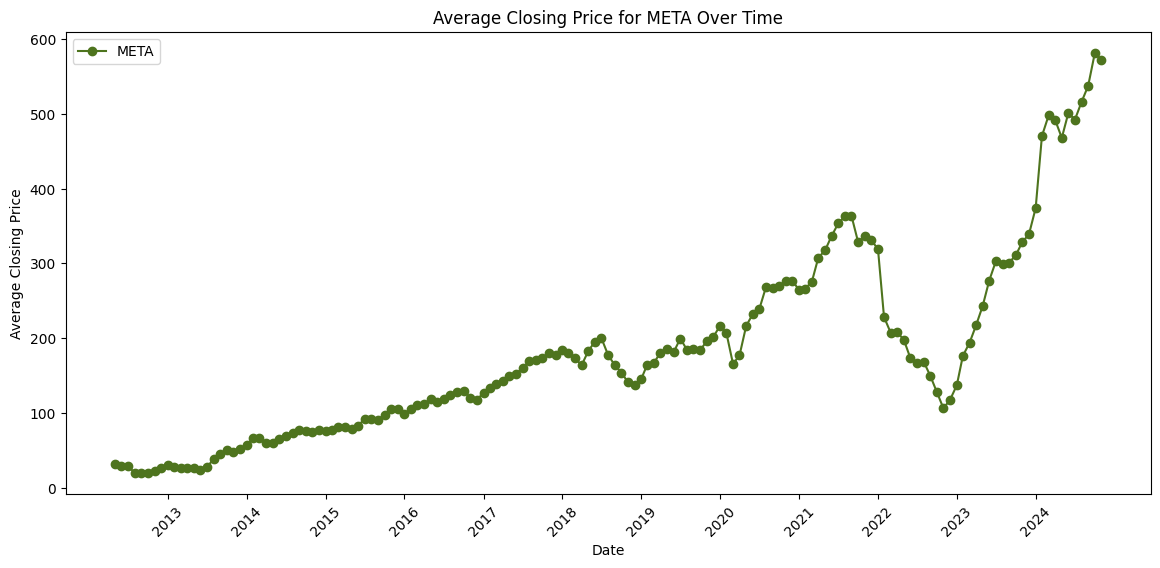

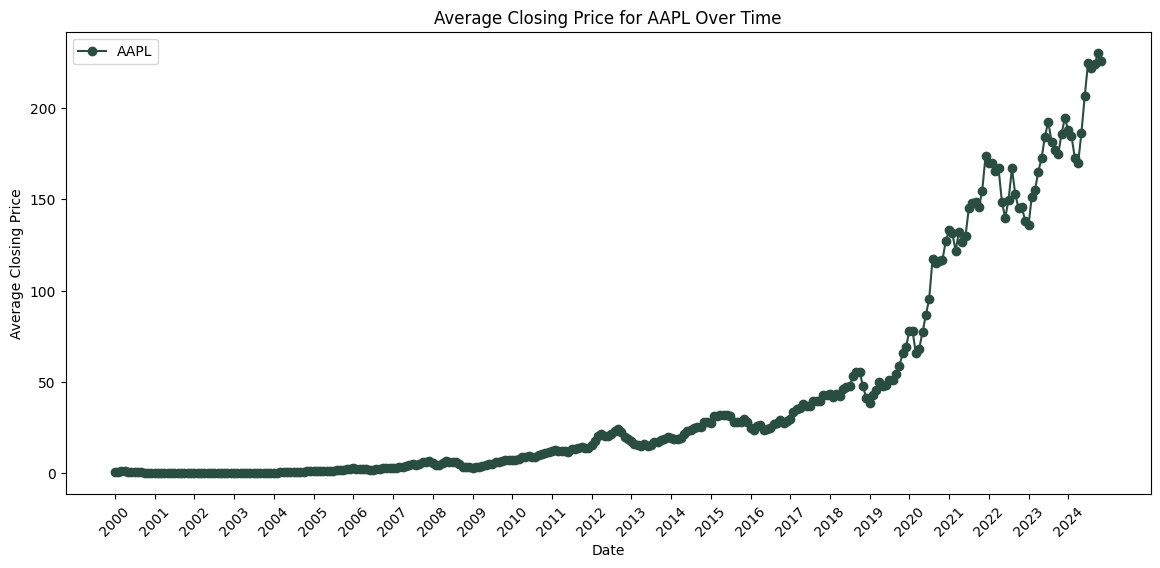

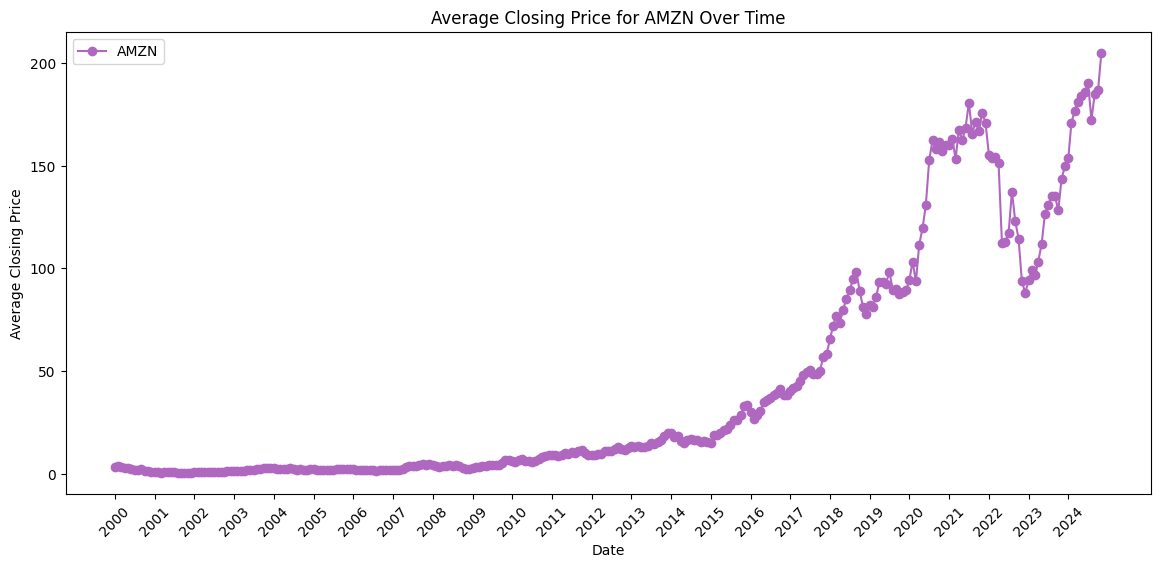

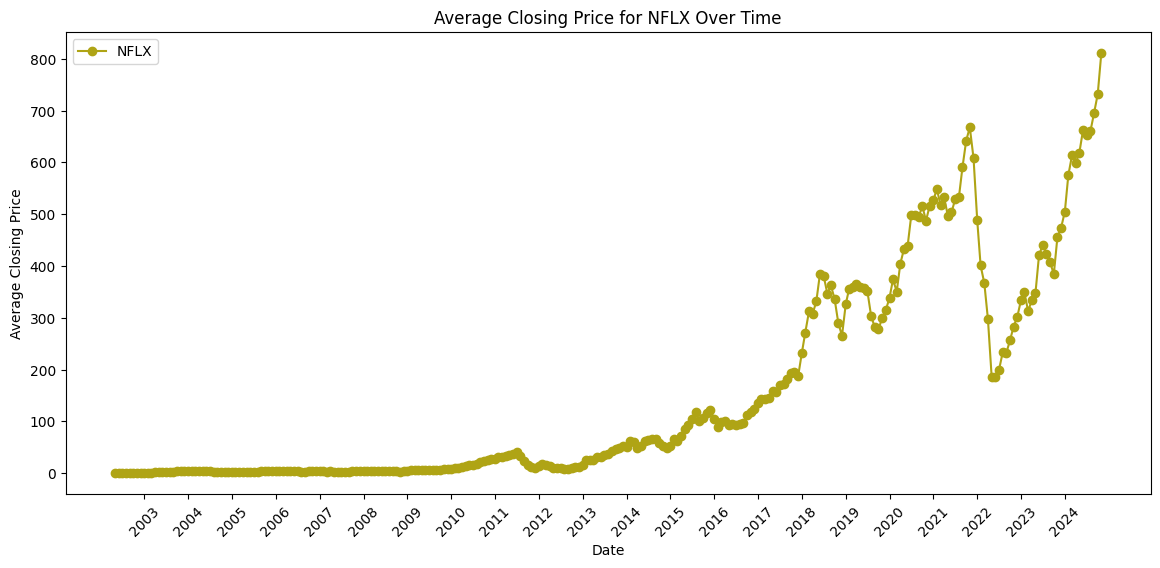

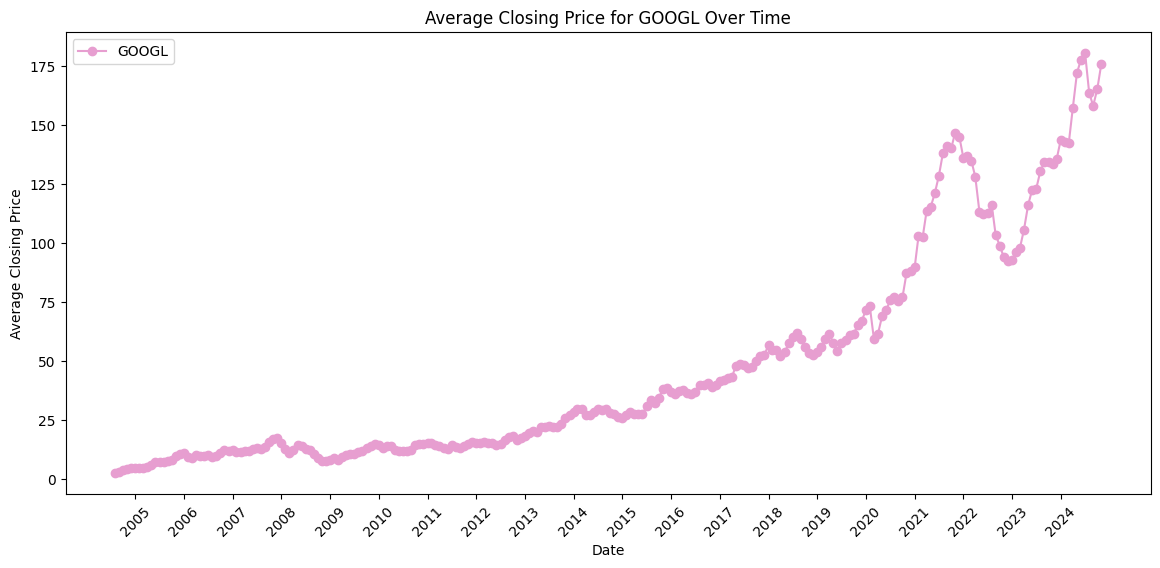

In [ ]:
# TODO: Plot each company ticker
for ticker in faang_tickers:
    ticker_data = average_closing_prices[average_closing_prices['Ticker'] == ticker]
    plt.figure(figsize=(14, 6))
    plt.plot(ticker_data['Date'], ticker_data['Close'], marker='o', linestyle='-', label=ticker, color=np.random.rand(3,))
    plt.xlabel('Date')
    plt.ylabel('Average Closing Price')
    plt.title(f'Average Closing Price for {ticker} Over Time')
    tick_dates = ticker_data[ticker_data['Date'].dt.month == 1]['Date']
    plt.xticks(ticks=tick_dates, labels=tick_dates.dt.year, rotation=45)
    plt.legend()
    plt.show()

## 1.3: Moving Average Model

Now that we have finished our EDA, we will begin fitting models to our data. We will aim to forecast `'AAPL'` stock prices (`'close'`) from this point onwards - please keep this in mind thoughout the remaining parts.

The first model we will apply to this model is a simple moving average model.

### 1.3.1: Define Moving Average Model Class [2 points]

**TODO:** In this exercise, you will complete the `MovingAverage` class. Complete the constructor below. Your final model should take in $q$, or the number of terms to consider in the moving average. The method `fit_transform` should take in target variable (time-series variable) `x`, and output the predictions returned based on your model architecture.

**Hint 1:** To debug your model, we recommend writing a few test cases as a sanity check.

**Hint 2:** What do you think the moving average model should do when there are not enough examples to average, especially during the initial steps? Can we use the mean\ of all available previous elements for the first few time steps?

In [ ]:
class MovingAverage:
  def __init__(self, q):
    ## TODO: Complete __init__ method
    self.q = q

  def fit_transform(self, x):
    ## TODO: Complete fit_transform method to return predictions returned by the model
    result = []
    for i in range(len(x)):
      window = x[max(0, i - self.q + 1): i + 1]
      result.append(np.mean(window))
    return result

In [ ]:
print(MovingAverage(4).fit_transform(np.arange(7)))

[np.float64(0.0), np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.5), np.float64(3.5), np.float64(4.5)]


In [ ]:
## Grader Cell - ? Points
model = MovingAverage(4)
grader.grade(test_case_id = "ma_architecture", answer = model.fit_transform(np.arange(7)))
# Will take in MA class and test it on our own data

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.3.2: Fit Moving Average Models to Data [2 points]

**TODO:** The next step is to fit the moving average models to your data. Fit five MA models trying different values of q from the list `[1, 10, 100, 1000, 5000]`, and compute the mean squared error between your moving average models and the actual ground truth data.


In [ ]:
apple_df = faang_df[faang_df["Ticker"] == "AAPL"]
apple_close = apple_df["Close"]

In [ ]:
## TODO: Fit MA models
ma_models = [MovingAverage(q) for q in [1, 10, 100, 1000, 5000]]
ma_predictions = [model.fit_transform(apple_close) for model in ma_models]
mse = [np.mean((pred - apple_close) ** 2) for pred in ma_predictions]

In [ ]:
## Grader Cell - ? Points
grader.grade(test_case_id = "ma_fit", answer = mse)
# Compares MSE values to our own - may want to allow some degree of leniency

Correct! You earned 2.0/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.3.3: Plot Moving Average Models [2 manually graded points]

**TODO:** Finally, plot on the same axis a line of your moving average model fits and the actual values in the time-series. Remember to include an axis title, labels, and legend in your plot, and to color code each of your models.

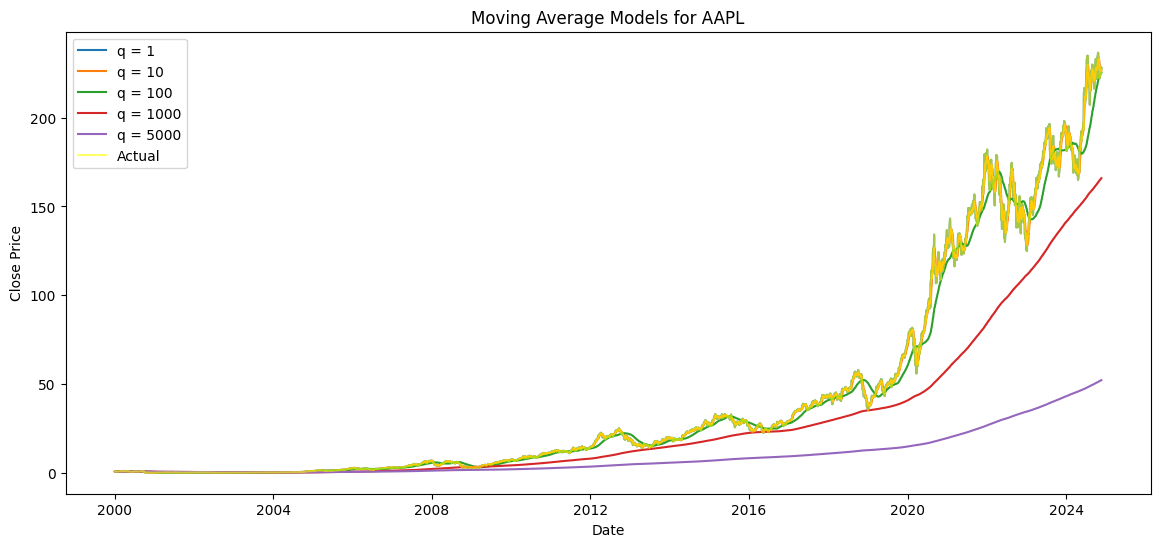

In [ ]:
## TODO: Plot Moving Average Models
plt.figure(figsize=(14, 6))
for i, pred in enumerate(ma_predictions):
    plt.plot(apple_df["Date"], pred, label=f"q = {ma_models[i].q}")
plt.plot(apple_df["Date"], apple_close, label="Actual", color="yellow", alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Moving Average Models for AAPL")
plt.legend()
plt.show()

# **Part 2:** Time-Series Machine Learning in Python [30 points]

Previously, we explored some traditional methods of time-series modelling. There are also a few other model types (such as exponential smoothing and Holt's Method), which we will not cover in this exercise. However, in this section, we will seek to apply machine learning methods to fit to our time-series data.

## 2.1: Loading our Data in `PyTorch` [5 points]

**TODOs:**
- Follow the TODOs below to prepare the `X` and `y` features for your model training:
 - Complete the `prepare_data` method to preprocess our data to input into our machine learning methods.
 - Define DataLoaders to feed into our machine learning algorithms using the `prepare_data` method.
 - Make sure to configure the `prepare_data` method to output tensors for both the train and test split! Specifically, you should do a **80% - 20% split**.

**Notes/Hints:**
- Remember - we will only be performing the prediction for the `'AAPL'` ticker.
- If you get stuck, imagine a sliding window of `sequence_length`:
 - `X` should be a tensor where each element is a particular sliding window (elements `i` to `i+sequence_length`) of the close prices. That is, `X` should be a tensor of tensors, each of length `sequence_length`.
 - `y` is a tensor where each element is the singular closing price of the point right after the sliding window of the corresponding `X` (element `sequence_length+i`).
- If you are confused by the idea of a sliding window in this section, remember the context in which we are applying machine learning - at each period of time, we are limiting the machine learning algorithm to only have access to a few previous data points (which are captured by the sliding window). These functions will help us to do this.

In [ ]:
def prepare_data(data, ticker, sequence_length):

    '''
    Inputs:
    data - input dataframe
    ticker - string representing the ticker we want to predict on
    sequence_length - integer representing length of the sliding window

    Outputs:
    X_train - tensor of "slices" captured by the sliding window for train set
    y_train - tensor of ground truth values for each time index for train set
    X_test - tensor of "slices" captured by the sliding window for test set
    y_test - tensor of ground truth values for each time index for test set
    scaler - fitted MinMaxScaler to the close prices
    '''
    # Common Problem: You are splitting X and y AFTER creating sliding windows
    # TODO: Filter data for the given ticker
    ticker_data = data[data["Ticker"] == ticker].sort_values('Date')
    close_prices = ticker_data["Close"].values.reshape(-1, 1)
    # TODO: apply a MinMaxScaler on the 'Close' prices
    split_index = int(len(close_prices) * 0.8)
    train_close = close_prices[:split_index]
    test_close = close_prices[split_index:]
    # TODO: Create X and y sequences
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_close)
    test_scaled = scaler.transform(test_close) # important, fit on train, not the whole dataset
    # TODO: return X (tensor), y (tensor), and the scaler
    X_train, y_train = [], []
    for i in range(len(train_scaled) - sequence_length):
        X_train.append(train_scaled[i:i+sequence_length])
        y_train.append(train_scaled[i+sequence_length])

    X_test, y_test = [], []
    for i in range(len(test_scaled) - sequence_length):
        X_test.append(test_scaled[i:i+sequence_length])
        y_test.append(test_scaled[i+sequence_length])

    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
    X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
    return X_train, y_train, X_test, y_test, scaler

In [ ]:
# Pass data in your prepare_data function
sequence_length = 500 #DO NOT CHANGE
ticker = 'AAPL'
X_train, y_train, X_test, y_test, scaler = prepare_data(faang_df, ticker, sequence_length)

In [ ]:
# TODO: Create DataLoaders (hint: pass in a TensorDataset of the X and y values into your DataLoader)
# HINT: make sure that you are NOT shuffling your data (why?)
dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

(4509, 4509, 753, 753)

In [ ]:
# Grader Cell - 5 Points
# DO NOT EDIT ANYTHING
trainLoaderCheck = [getattr(train_loader, "batch_size"),
                    str(type(train_loader)),]
testLoaderCheck = [getattr(test_loader, "batch_size"),
                    str(type(test_loader)),]
grader.grade(test_case_id = "data_prep", answer = (len(X_train), len(y_train), len(X_test), len(y_test), trainLoaderCheck, testLoaderCheck))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.2: Recurrent Neural Network (RNN)

RNNs are neural networks trained on sequential data (ex: time series data or sequence of words). It is great at capturing temporal relationships. Using the past sequence, it can predict future values, making it a suitable model for forecasting.


Below, we have an example of an RNN architecture. It has multiple hidden layers, as well as an output layer.
Unlike a FCN, an RNN model shares the parameters across different layers. This allows the weights (U) to learn the data in a sequential way by remembering data from previous steps.

At each step, an output y is generated. During backpropagation, this model will calculate the loss of the predicted output at each time step versus the actual output.

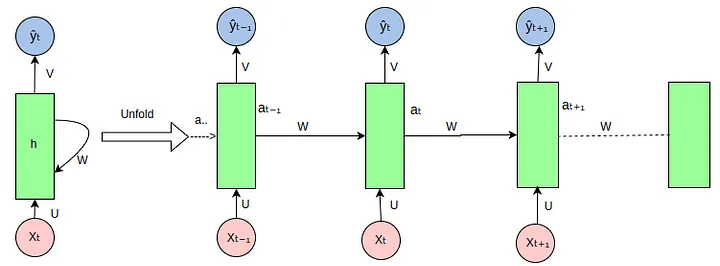

### 2.2.1: Define RNN Architecture in `PyTorch` [5 points]

**TODOs:** Now, you will implement this RNN architecture in `PyTorch`.
- Follow the TODOs below and define an RNN model class.
- You may also refer to the figure above and the `PyTorch` documentation for guidance.


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # TODO: Define stacked RNN layers (see nn.RNN)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # TODO: Define a fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        # Initialize hidden state of zeros if it doesn't exist
        if hidden is None:
            hidden = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass x and the hidden state through RNN layer
        out, hidden = self.rnn(x, hidden)

        # Pass the last output of the sequence to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out, hidden

In [ ]:
# TODO: RNN: come up with relevant hyperparameters
input_size = 1
hidden_size = 64
output_size = 1
num_layers = 2

model = RNN(input_size, hidden_size, output_size, num_layers)
print(model)

RNN(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Grader Cell - 5 Points
grader.grade('define_rnn', answer = (str(model), input_size, hidden_size, output_size, num_layers))

Correct! You earned 5.0/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2.2: Fit/train RNN Model [3 points]

Excellent - now that the RNN model has been defined, let's train it on our model.

**TODO:** Complete the `train_model` function, which defines a training loop for us to use in the subsequent parts.

**Hints:**
* If you are still confused on training loops, we encourage you to refer to your code for the HW 5 main path. Note that even though we have changed the model architecture from an FCN/CNN to an RNN, `Pytorch` provides the same framework for training all of these algorithms, so we can use a very similarly-structured training loop.
* You will need to decide on appropriate parameters for the model. If you are getting a very poor loss value/losing points on the autograder, consider changing your model parameters.

In [ ]:
# set seed
torch.manual_seed(42)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    '''
    Inputs:
    - model: instantiated machine learning model to be trained
    - train_loader: DataLoader object containing training data for the model
    - criterion: loss criterion on which to train the model on
    - optimizer: PyTorch optimizer object
    - epochs: number of epochs
    '''
    loss_list = []
    model = model.to(device)
    criterion = criterion.to(device)
    model.train()
    # TODO: Implement the training loop - including printouts for each epoch's loss value
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output, _ = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_list.append(total_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}")
    return loss_list

# 4. Initialize and train the model above (not a TODO)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_list = train_model(model, train_loader, criterion, optimizer)

Epoch 1/100, Loss: 0.004481564043790615
Epoch 2/100, Loss: 0.05107994130474976
Epoch 3/100, Loss: 0.030539047852084392
Epoch 4/100, Loss: 0.012517918810443278
Epoch 5/100, Loss: 0.0017572383317975494
Epoch 6/100, Loss: 0.00018976321150917779
Epoch 7/100, Loss: 0.00020540966033978127
Epoch 8/100, Loss: 0.0001942279948829187
Epoch 9/100, Loss: 0.00018973131828144997
Epoch 10/100, Loss: 0.00018634539934437463
Epoch 11/100, Loss: 0.0001854646531605068
Epoch 12/100, Loss: 0.00018719548455510933
Epoch 13/100, Loss: 0.00019107340173637883
Epoch 14/100, Loss: 0.00019560066530010606
Epoch 15/100, Loss: 0.0001986023933911983
Epoch 16/100, Loss: 0.00019840175732037716
Epoch 17/100, Loss: 0.0001947693747345685
Epoch 18/100, Loss: 0.00018857534245260028
Epoch 19/100, Loss: 0.00018088778437758176
Epoch 20/100, Loss: 0.00017255176404019231
Epoch 21/100, Loss: 0.0001641963413198969
Epoch 22/100, Loss: 0.00015631417727369828
Epoch 23/100, Loss: 0.00014929547168264688
Epoch 24/100, Loss: 0.0001434275034

NOTE: Your loss values may seem low. This is because in the data prep section, we scaled all the values from 0 to 1, which yields a small loss (even though there may be errors)

In [ ]:
# Grader Cell - 3 Points
# Test on the loss values
grader.grade('rnn_loss', answer=loss_list)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2.3: Evaluate RNN Model [4 manually graded points]

**TODO:** Finally, we will evaluate the RNN model on the test data.
- Complete the below `evaluate_model` method to evaluate your model on the test data.
- Complete the `plot_predictions_over_time` function to generate a plot of the predicted values. The function should plot both the ground truth values and the model prediction on the same pair of axes. Remember to include a figure title, axis titles, and legend in your function.

In [ ]:
def evaluate_model(model, test_loader, scaler):
    '''
    Inputs:
    - model: the (trained) model to be tested
    - test_loader: DataLoader containing test dataset
    - scaler - fitted MinMaxScaler to the close prices
    '''
    model = model.to(device)
    model.eval()
    # TODO: Implement test data loop
    predictions = []
    actuals = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            predictions.extend(output.cpu().numpy().flatten())
            actuals.extend(target.cpu().numpy().flatten())
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))
    return predictions, actuals

In [ ]:
predictions, actuals = evaluate_model(model, test_loader, scaler)

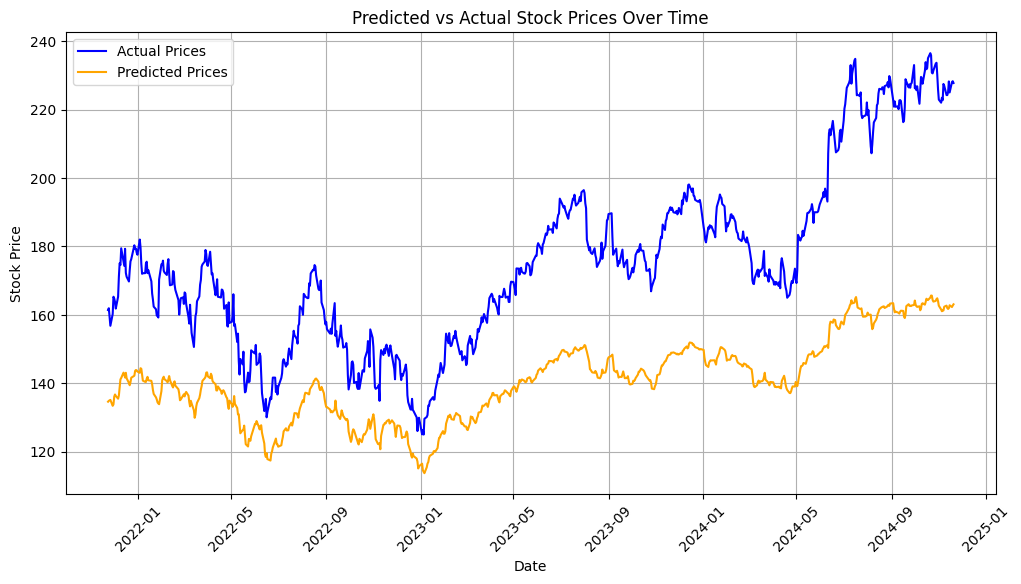

Final Loss: 1406.64111328125


In [ ]:
def plot_predictions_over_time(test_loader, predictions, actuals, test_data, criterion):
    '''
    Inputs:
    - test_loader: DataLoader object containing test data
    - predictions: Tensor containing model predictions
    - actuals: Tensor containing actual target values
    - test_data: DataFrame containing all data
    '''
    # Extract dates from test dataset
    test_dates = test_data['Date'][-len(actuals):].values  # Ensure dates align with test data

    # Plot predicted and actual prices
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, actuals, label="Actual Prices", color="blue")
    plt.plot(test_dates, predictions, label="Predicted Prices", color="orange")
    plt.title("Predicted vs Actual Stock Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()
    predictions = torch.tensor(predictions)
    actuals = torch.tensor(actuals)

    loss = criterion(predictions, actuals)
    print(f"Final Loss: {loss}")

# Call the plotting function
criterion = torch.nn.MSELoss()
test_data = faang_df[faang_df['Ticker'] == ticker].sort_values('Date')
plot_predictions_over_time(test_loader, predictions, actuals, test_data, criterion)

## 2.3: Long-Term Short-Term (LSTM) Model

Now, we will introduce another type of time-series machine learning model, the Long-Term Short-Term (LSTM) model. This is also a form of deep learning that works similarly to an RNN, but tends to "remember" long term data more effectively. Long-term data is stored in a gate, which is added on to every time-series instance later on down the line. During training, the model decides whether or not individual examples should be included in memory (input gate). Previous states are also removed (forget gate) and added to the prediction (input gate) at each point in time, contributing to the final prediction. This is more effective at including previous entries "long-term" so they contribute to subsequent predictions down the line.

For more details, feel free to visit the lecture slides on Transformers and Time-Varying data.

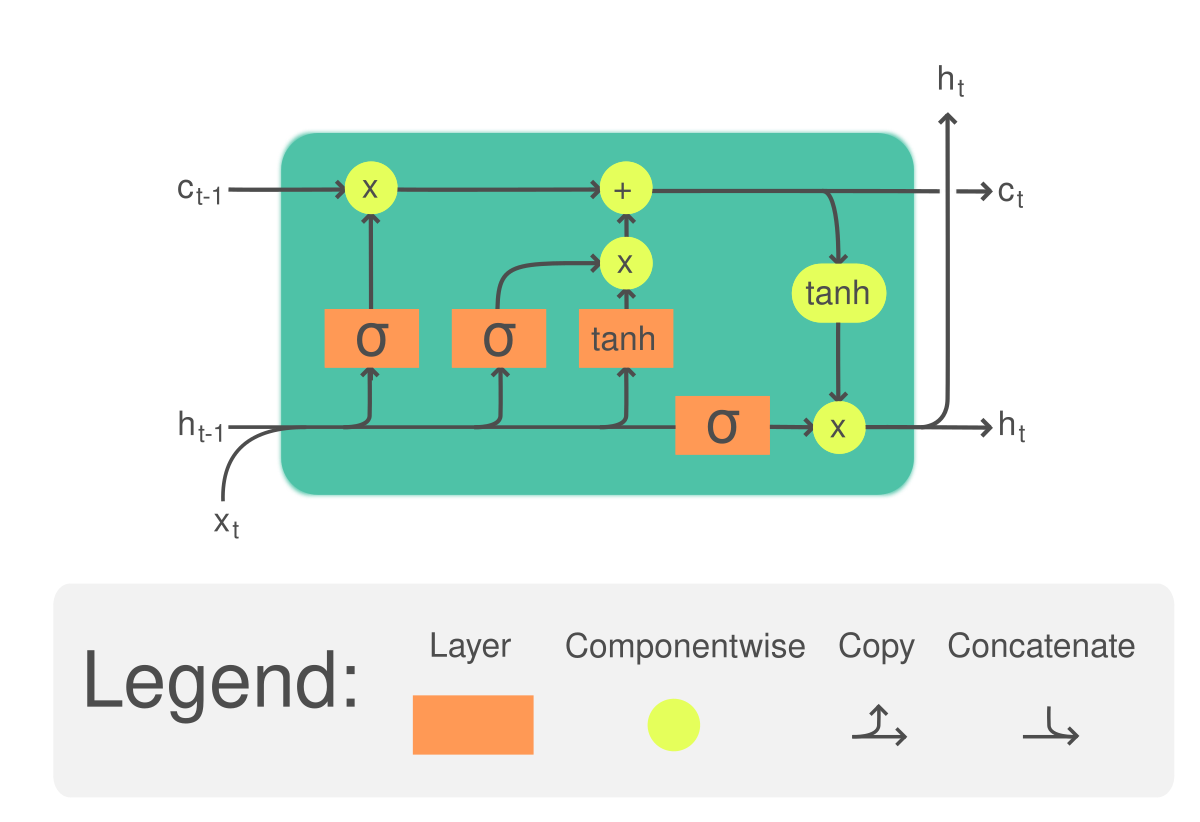

### 2.3.1: Define LSTM Architecture [5 points]

In [ ]:
## TODO: Create a class for building LSTM models
class LSTM(nn.Module):
    # TODO: Create a constructor
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        # TODO: Define stacked LSTM layers
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # TODO: Define a fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

        # TODO: Create a feed forward method
    def forward(self, x, hidden=None):
        # TODO: Initialize hidden and cell states if not provided
        if hidden is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        else:
            h0, c0 = hidden

        # TODO: Pass through LSTM layers
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # TODO: Pass the last time step's output through the fully connected layer
        out = self.fc(out[:, -1, :]) # Only take the last time step output
        return out, (hn, cn)

In [ ]:
# TODO: LSTM: Initialize variables with parameters
input_size = 1
hidden_size = 64
output_size = 1
num_layers = 4

model = LSTM(input_size, hidden_size, output_size, num_layers)

In [ ]:
model

LSTM(
  (lstm): LSTM(1, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
# Grader Cell
grader.grade('define_lstm', answer = (str(model), input_size, hidden_size, output_size, num_layers))

Correct! You earned 5.0/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3.2: Fit/train LSTM Model [3 points]

Now that the LSTM model has been defined, let's train it on our model.

**TODO:** Complete the `train_model` function, which defines a training loop for us to use in the subsequent parts. You can use the `DataLoader` objects that we previously defined.

**Hints:**
* If you are still confused on training loops, we encourage you to refer to your code for the HW 5 main path. Note that even though we have changed the model architecture from an FCN/CNN to an RNN, `Pytorch` provides the same framework for training all of these algorithms, so we can use a very similarly-structured training loop.
* You will need to decide on appropriate parameters for the model. If you are getting a very poor loss value/losing points on the autograder, consider changing your model parameters.

In [ ]:
## TODO: Train your LSTM model
# TODO: Instantiate criterior (MSE loss), and optimizer (adam, with learning rate 0.001)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# TODO: Train model
loss_list = train_model(model, train_loader, criterion, optimizer)

Epoch 1/100, Loss: 0.006403706563163568
Epoch 2/100, Loss: 0.06263439885152101
Epoch 3/100, Loss: 0.06727888786414776
Epoch 4/100, Loss: 0.055181121450598294
Epoch 5/100, Loss: 0.03350039938554446
Epoch 6/100, Loss: 0.012159894062446617
Epoch 7/100, Loss: 0.00629348836032187
Epoch 8/100, Loss: 0.0035335571818846958
Epoch 9/100, Loss: 0.0027162524227683305
Epoch 10/100, Loss: 0.002175696241299534
Epoch 11/100, Loss: 0.0018449181590787045
Epoch 12/100, Loss: 0.0016283992155372322
Epoch 13/100, Loss: 0.0014730585301183526
Epoch 14/100, Loss: 0.0013561882010258127
Epoch 15/100, Loss: 0.0012671911122036086
Epoch 16/100, Loss: 0.0012004320496781145
Epoch 17/100, Loss: 0.00115231896779249
Epoch 18/100, Loss: 0.0011196611907901227
Epoch 19/100, Loss: 0.0010985575030820894
Epoch 20/100, Loss: 0.0010840029494796392
Epoch 21/100, Loss: 0.0010706821285848748
Epoch 22/100, Loss: 0.0010545928158851455
Epoch 23/100, Loss: 0.0010340554864141298
Epoch 24/100, Loss: 0.0010093266361364188
Epoch 25/100, L

In [ ]:
# Grader Cell
grader.grade(test_case_id="lstm_loss", answer=loss_list)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3.3: Evaluate LSTM Model [4 manually graded points]

**TODO:** Finally, we will evaluate the LSTM model on the test data.
- Use the `evaluate_model` method to evaluate your model on the test data.
- Use the `plot_predictions_over_time` function to generate a plot of the predicted values. The function should plot both the ground truth values and the model prediction on the same pair of axes. Remember to include a figure title, axis titles, and legend in your function.

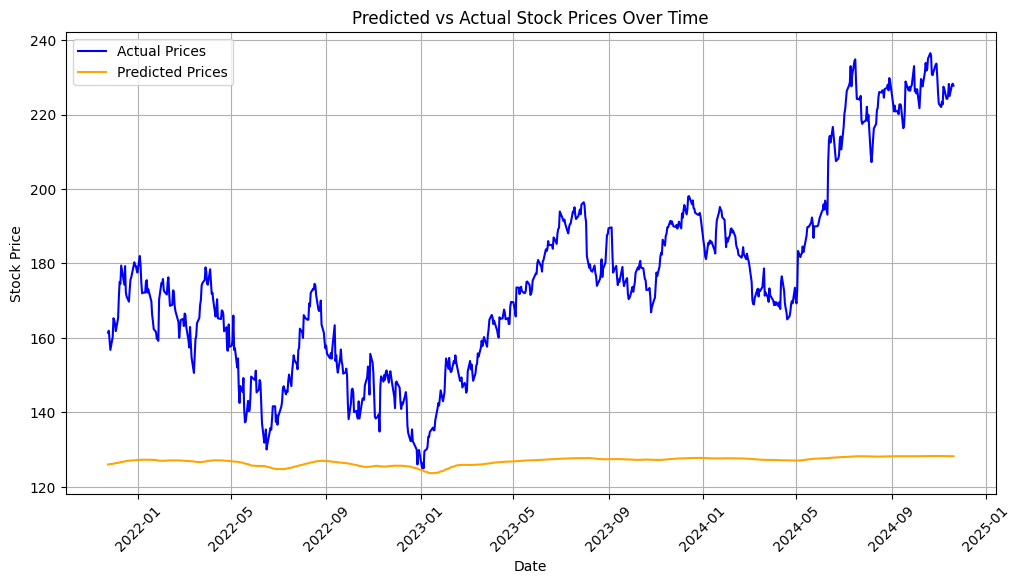

Final Loss: 2998.041748046875


In [ ]:
predictions, actuals = evaluate_model(model, test_loader, scaler)
criterion = torch.nn.MSELoss()
plot_predictions_over_time(test_loader, predictions, actuals, test_data, criterion)

## 2.4: Reflection (1 manually graded point)

You've now had exposure to traditional time-series models, as well as machine learning time-series analysis tools. Write a brief reflection on your takeaways from using these models in this setting:
* What are some unique challenges associate with time-series data, and how can we overcome these in practice?

Using future data during training is a major problem. Previously, I generated input X and output y from the entire dataset first, and then split into training and testing sets. This caused the training set to contain data that should have belonged to the testing set.
In fact, the correct approach is to first split the dataset into training and testing sets, and then generate the input-output pairs separately for each.
* What are some of the advantages/disadvantages of using traditional vs. deep learning methods for time-series analysis?

Traditional methods:

Advantages: Strong interpretability, work well with small and clean datasets.

Disadvantages: Limited ability to capture complex patterns.

Deep learning methods:

Advantages: Can model complex, nonlinear relationships and handle large datasets.

Disadvantages: Require more data, harder to interpret, and risk of overfitting.

# **Part 3:** Streaming [10 points]

Description: In this part, you will be given a streaming dataset of FAANG stock prices. Your task is to compute the average volume of each stock over a 5-day window, and then write the results to a memory sink. You will then query the sink to get the results.

This simulates a real-time scenario where you are given a stream of data, and you need to compute some summary statistics on the fly.

You might find these documentations on writeStream for Apache Spark helpful:

https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html
https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.writeStream.html


In [ ]:
###### DO NOT EDIT ######
!pip install pyspark

In [ ]:
###### DO NOT EDIT ######
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType

In [ ]:
###### DO NOT EDIT ######
# Create Spark Session with additional configurations
spark = SparkSession.builder \
    .appName("FAANG Streaming") \
    .config("spark.sql.streaming.checkpointLocation", "/tmp/checkpoint") \
    .getOrCreate()

In [ ]:
# TODO: Define schema based on faang_df
schema = StructType([
    StructField("Unnamed: 0", DoubleType(), True),
    StructField("Date", TimestampType(), True),
    StructField("Ticker", StringType(), True),
    StructField("Open", DoubleType(), True),
    StructField("High", DoubleType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Adj Close", DoubleType(), True),
    StructField("Volume", DoubleType(), True)
])

In [ ]:
!wget https://storage.googleapis.com/penn-cis5450/faang_part_0.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_1.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_2.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_3.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_4.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_5.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_6.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_7.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_8.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_9.csv

--2025-04-28 20:02:36--  https://storage.googleapis.com/penn-cis5450/faang_part_0.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.250.4.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251204 (245K) [text/csv]
Saving to: ‘faang_part_0.csv’

faang_part_0.csv    100%[===================>] 245.32K   405KB/s    in 0.6s    

2025-04-28 20:02:36 (405 KB/s) - ‘faang_part_0.csv’ saved [251204/251204]

--2025-04-28 20:02:36--  https://storage.googleapis.com/penn-cis5450/faang_part_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.250.4.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236487 (231K) [text/csv]
Saving to: ‘faang_part_1.csv’

faang_part_1.csv    100%[===

In [ ]:
!mkdir stream_data
!mv *.csv stream_data

In [ ]:
# Read streaming data with explicit schema and more robust options
faangStreamDF = spark.readStream \
    .format("csv") \
    .option("header", "true") \
    .option("sep", ",") \
    .option("maxFilesPerTrigger", 1) \
    .schema(schema) \
    .load("/content/stream_data/")

In [ ]:
# TODO: Convert Date to timestamp
# Is it necessary?

In [ ]:
# TODO: Complete windowed aggregation
faang_volume_summary = faangStreamDF.groupBy(
    window(col("Date"), "5 days", "1 day"),
    col("Ticker")
).agg(avg("Volume").alias("avg_volume"))

In [ ]:
# TODO: Write to memory sink with complete output mode
query = faang_volume_summary.writeStream \
    .format("memory") \
    .queryName("faang_volume_summary") \
    .outputMode("complete") \
    .start()

In [ ]:
###### DO NOT EDIT ########
# Wait for the query to start processing
query.awaitTermination(15)  # Wait for 15 seconds to ensure data is processed

# Adding a slight delay before showing results to ensure processing is completed
import time
time.sleep(25)  # Add a delay before calling show()

# Show results
faang_summary_df = spark.sql("SELECT * FROM faang_volume_summary ORDER BY Ticker, window").toPandas().reset_index(drop=True)
faang_summary_df.head(20)

,window,Ticker,avg_volume
0,"(1999-12-30 00:00:00, 2000-01-04 00:00:00)",AAPL,5.357968e+08
1,"(1999-12-31 00:00:00, 2000-01-05 00:00:00)",AAPL,5.240872e+08
2,"(2000-01-01 00:00:00, 2000-01-06 00:00:00)",AAPL,6.088320e+08
3,"(2000-01-02 00:00:00, 2000-01-07 00:00:00)",AAPL,6.486172e+08
4,"(2000-01-03 00:00:00, 2000-01-08 00:00:00)",AAPL,6.110406e+08
5,"(2000-01-04 00:00:00, 2000-01-09 00:00:00)",AAPL,6.298516e+08
6,"(2000-01-05 00:00:00, 2000-01-10 00:00:00)",AAPL,6.690096e+08
7,"(2000-01-06 00:00:00, 2000-01-11 00:00:00)",AAPL,5.779237e+08
8,"(2000-01-07 00:00:00, 2000-01-12 00:00:00)",AAPL,4.691157e+08
9,"(2000-01-08 00:00:00, 2000-01-13 00:00:00)",AAPL,6.408939e+08


In [ ]:
print(len(faang_summary_df))

9164


In [ ]:
faang_summary_pandas = faang_summary_df.copy()
faang_summary_pandas['window'] = faang_summary_pandas['window'].apply(lambda x: str(x))

In [ ]:
# Grader Cell
grader.grade(test_case_id = "streaming_test", answer = (faang_summary_pandas.head(20), len(faang_summary_df)))

You earned 3/10 points.

Too few rowsDon't worry, you can re-submit and we will keep only your latest score.


# Submission Guidelines:

Congratulations on finishing this part of HW 5! When you are ready to submit on Gradescope, please submit a .py and .ipynb of this notebook.

**A few reminders:**
* **Double check** that you have the correct PennID (all numbers) in the autograder.

* **Triple check** that you fulfilled all the requirements mentioned in the beginning of the notebook.

* You must submit your notebook to receive credit. Post any issues with submission on Ed and make sure to keep in mind the late day policy.

* After you submit your code, the teaching staff will manually grade your Colab notebook in order to validate the correctness of your code.

* Please remember to follow best practices for graphs and HW assignment submission as stated on Ed.